# NDVI de Terra/MODIS Time Series Unsupervised Classification with Kmeans with GEE Python API (Second attempt)

In [1]:
# Install necessary packages in Colab
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 34.6 MB/s eta 0:00:00


## Import libraries

In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-my-francodbarr') # NOTE: change according to your GEE project name

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import geemap
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import shape
from shapely.geometry import Point
import rasterio
import random
from google.colab import files

## Data and layers importing

### Clusters' first selection vector importing and conversion

In [4]:
# Import vector file from the GH repo + unzipping
!wget https://github.com/francobarrionuevoenv21/ClusteringPaddyFields_Fires_SanJavier/raw/refs/heads/main/Data_results/kmeans_seleccion_vectorizado_primerclasf.zip
!unzip kmeans_seleccion_vectorizado_primerclasf

--2025-06-23 00:51:25--  https://github.com/francobarrionuevoenv21/ClusteringPaddyFields_Fires_SanJavier/raw/refs/heads/main/Data_results/kmeans_seleccion_vectorizado_primerclasf.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/francobarrionuevoenv21/ClusteringPaddyFields_Fires_SanJavier/refs/heads/main/Data_results/kmeans_seleccion_vectorizado_primerclasf.zip [following]
--2025-06-23 00:51:25--  https://raw.githubusercontent.com/francobarrionuevoenv21/ClusteringPaddyFields_Fires_SanJavier/refs/heads/main/Data_results/kmeans_seleccion_vectorizado_primerclasf.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [7]:
# Vector file reading
targetCRS = "EPSG:4326"
vectorClustSel = gpd.read_file('/content/kmeans_seleccion_vectorizado.shp').to_crs(targetCRS)

<Axes: >

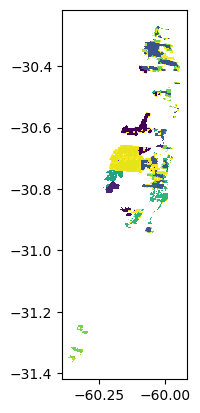

In [11]:
# Plot and check vector data
vectorClustSel.plot(column='DN')

In [12]:
# getCoordsSHP function
def getCoordsSHP(gdfshpFile):
  '''
  This function takes a polygon vector file passed as a GeoDataFrame. Then
  it returns all the coordinates as a tuple of tuples.
  '''

  gdfiterf = gdfshpFile.iterfeatures()
  tupleFile = next(gdfiterf)['geometry']['coordinates']

  return tupleFile

# Get ids of each polygon
listIDs = list(vectorClustSel['fid'])

# Create a empty list to fill with ee polygons
listPolys = []

# Extracts coordinates from each polygon and convert to ee polygons
for ID in listIDs:
  listOfLists = [list(coords) for coords in getCoordsSHP(vectorClustSel[vectorClustSel['fid']==ID])[0]] # Get vector coordinates as a tuple of tuples
  listPolys.append(ee.Geometry.Polygon(listOfLists)) # Coordinates to a EE.Polygon

# Convert polygons to feature collection
featureCollection02 = ee.FeatureCollection(listPolys)

### MODIS NDVI data retrieving from GEE catalog
#### https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13Q1

In [17]:
# MODIS MOD13Q1 NDVI data selection
MODIS = ee.ImageCollection('MODIS/006/MOD13Q1').select('NDVI') # MOD13Q1.061 Terra Vegetation Indices 16-Day Global 250m

# Time range selection
startDate = '2000-02-18'
endDate = '2022-12-31'

# Image collection filtering by time range
MODIS = MODIS.filterDate(startDate, endDate)

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD13Q1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1

  warnings.warn(warning, category=DeprecationWarning)


In [18]:
# Check data retrieving
print(type(MODIS))
print(MODIS.size().getInfo())

<class 'ee.imagecollection.ImageCollection'>
526


In [19]:
# Define a function to unmask the NDVI band
def unmaskNDVI(image):
    return image.select('NDVI').unmask(-2000)

# Map the unmask function over the entire collection
MODIS_unmasked = MODIS.map(unmaskNDVI)

In [20]:
# Convert the image collection to a stack of images
MODIS_stack = MODIS_unmasked.toBands()
print(type(MODIS_stack))

<class 'ee.image.Image'>


In [21]:
# Clip the stack of images according to the study area
MODIS_stack = MODIS_stack.clipToCollection(featureCollection02)

In [42]:
# Generate interactive map to check images clipping
Map = geemap.Map(center=(-30.78, -60.12), zoom=9)
Map.addLayer(MODIS_stack.select(0), {'min': -2000, 'max': 10000, 'palette': ['yellow', 'red']}) # Add visualization parameters

Map

Map(center=[-30.78, -60.12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

## K-means classification of the study area
#### Kmeans in GEE description: https://developers.google.com/earth-engine/guides/clustering

### Initialization/training dataset

In [ ]:
'''
NOTE: Running the Kmeans algorithm in GEE requires random training points as input
'''

# Define the region to generate the input sample
region = featureCollection02
# Pixel spatial resolution in meters
scale = 250
# Number of initialization/training points
numPixels = 5000

# Make the training dataset
MODIS_randomtraining = MODIS_stack.sample(region=region, scale=scale, numPixels=numPixels)

### Study area classification

In [ ]:
'''
NOTE: The criteria for the number of classification clusters was defined as
80% of the prior classification types
'''
# Define the number of clusters for classification
num_clusters = 40
seed = 42

# Train the Kmeans classifier
kmeans = ee.Clusterer.wekaKMeans(num_clusters, seed=seed).train(MODIS_randomtraining)

In [ ]:
# Apply the classifier over the stack of images (Time series classification)
MODIS_kmeans = MODIS_stack.cluster(kmeans) # Pixels are classified as 0 to n_clusters-1
MODIS_kmeans = MODIS_kmeans.add(1) # Sum 1 so the first cluster id different to 0

# Clip the image classified according to vector of the study area
MODIS_kmeans = MODIS_kmeans.clip(featureCollection02)

In [ ]:
# Check image output format
print(type(MODIS_kmeans))

### Output visualization

In [ ]:
Map = geemap.Map(center=(-32.06, -60.62), zoom=9)
Map.addLayer(MODIS_kmeans)

Map

### Export the final classification

In [ ]:
'''
Tutorial for large images exporting from GEE
https://worldbank.github.io/OpenNightLights/tutorials/mod3_7_import_export_data.html
'''

task = ee.batch.Export.image.toDrive(
        image = MODIS_kmeans.toDouble(),
        scale=scale,
        region = featureCollection02.geometry().bounds(), # Or use custom ee.Geometry.Rectangle([minlon, minlat, maxlon, maxlat])
        description = 'MODIS_MOD13Q1_NDVI_kmeans40-24-03.tif', # Define the name of the exported file
        crs = 'EPSG:4326',
        maxPixels = 1e10, # Avoid limits in memory usage
        fileFormat = "GeoTIFF",
        folder ='earthengine'
  )

task.start() # Find the final image in Google Drive folder

## Summary of cluster's classes

#### Data sampling to reconstruct the timeseries of each classification

In [46]:
# Import image with the classification from the GH repo
# If any error with the link, you can find the file here: https://github.com/francobarrionuevoenv21/ClusteringPaddyFields_Fires_SanJavier/blob/main/Data_results/03_MODIS_MOD13Q1_NDVI_kmeans40-24-03-integer.tif
!wget https://github.com/francobarrionuevoenv21/ClusteringPaddyFields_Fires_SanJavier/raw/refs/heads/main/Data_results/03_MODIS_MOD13Q1_NDVI_kmeans40-24-03-integer.tif

--2025-06-23 03:29:17--  https://github.com/francobarrionuevoenv21/ClusteringPaddyFields_Fires_SanJavier/raw/refs/heads/main/Data_results/03_MODIS_MOD13Q1_NDVI_kmeans40-24-03-integer.tif
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/francobarrionuevoenv21/ClusteringPaddyFields_Fires_SanJavier/refs/heads/main/Data_results/03_MODIS_MOD13Q1_NDVI_kmeans40-24-03-integer.tif [following]
--2025-06-23 03:29:17--  https://raw.githubusercontent.com/francobarrionuevoenv21/ClusteringPaddyFields_Fires_SanJavier/refs/heads/main/Data_results/03_MODIS_MOD13Q1_NDVI_kmeans40-24-03-integer.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiti

In [47]:
# Load raster classification
raster_file = "/content/03_MODIS_MOD13Q1_NDVI_kmeans40-24-03-integer.tif"
with rasterio.open(raster_file) as src:
    classification = src.read(1)
    transform = src.transform
    num_clusters = len(np.unique(classification))

### Create a dataset with random sampling points of the obtained classification

In [ ]:
# Set the number of sampling points for each cluster
num_points_per_cluster = 100

# Initialize lists for storing the sampling points data
points = []
cluster_numbers = []

# Ieration for generating the sampling points randomly
for cluster_id in range(1, num_clusters + 1):
    cluster_indices = np.where(classification == cluster_id)
    sample_indices = random.sample(range(len(cluster_indices[0])), min(num_points_per_cluster, len(cluster_indices[0])))

    for index in sample_indices:
        row, col = cluster_indices[0][index], cluster_indices[1][index] # Gets the index of each pixel
        x, y = rasterio.transform.xy(transform, row, col) # Extracts the coordinates from each pixel
        points.append(Point(x, y))
        cluster_numbers.append(cluster_id)


# Create a GeoDataFrame from the points
data = {'geometry': points, 'cluster': cluster_numbers}
gdf = gpd.GeoDataFrame(data, crs=src.crs)

# Save the GeoDataFrame to a shapefile
output_shapefile = "kmeans_random_points_2dokmeans.shp"
gdf.to_file(output_shapefile)

print("Random points saved to:", output_shapefile)

### Data sampling from the original MODIS dataset to reconstruct the TS

In [ ]:
modis_collection = MODIS

clusters = gdf["cluster"].unique()

# Create a function to extract NDVI values for a point
def get_ndvi_for_point(feature):
    point = feature.geometry()
    ndvi_values = modis_collection.getRegion(point, scale=250).getInfo()
    return ndvi_values

# Loop through each cluster and extract NDVI values for each point
ndvi_data = []

for cluster in clusters:
    cluster_gdf = gdf[gdf["cluster"] == cluster]
    for index, row in cluster_gdf.iterrows():
        point = Point(row["geometry"].x, row["geometry"].y)
        feature = ee.Feature(ee.Geometry.Point(point.x, point.y))
        ndvi_values = get_ndvi_for_point(feature)

        # Extract NDVI values for each scene
        for scene_values in ndvi_values[1:]:
            timestamp_milliseconds = int(scene_values[3])
            timestamp_seconds = timestamp_milliseconds / 1000
            dt_object = dt.utcfromtimestamp(timestamp_seconds)
            formatted_date = dt_object.strftime('%Y-%m-%d')

            scene_ndvi_values = scene_values[4:]
            ndvi_data.append([cluster, point.x, point.y, formatted_date, *scene_ndvi_values])

# Create a dataframe from the extracted data
columns = ["cluster", "longitude", "latitude", "date"] + ["NDVI" + str(i) for i in range(1, len(ndvi_data[0]) - 3)]
ndvi_df = pd.DataFrame(ndvi_data, columns=columns)

In [ ]:
# Fill Nan values with -2000 (same as with the unmasking done before)
ndvi_df = ndvi_df.fillna(-2000)

In [ ]:
# Display the dataFrame (Optional)
#ndvi_df

In [ ]:
# Pivot the DataFrame to have one column per date
pivot_df = ndvi_df.pivot_table(
    index=["cluster", "longitude", "latitude"],
    columns="date",
    values=["NDVI1"],  # List all the NDVI columns here
    aggfunc="first"  # You can adjust the aggregation function if needed
)

# Reset the index to make columns regular columns
pivot_df.reset_index(inplace=True)

# Display the pivoted DataFrame (Optional)
#pivot_df

### Export data

In [ ]:
# Export the final csv
pivot_df.to_csv("kmeans_ndvi_pivot-2.csv", index=False)
files.download('kmeans_ndvi_pivot-2.csv')

# Optional
#ndvi_df.to_csv("kmeans_ndvi.csv", index=False)
#files.download('kmeans_ndvi.cs')